# My Strava Data Playground

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime


/Users/brendanlai/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load data and some data management
df = pd.read_csv("data/activities_updated.csv")
df['Activity Date'] = pd.to_datetime(df['Activity Date'])
df = df.sort_values(by=['Activity Date'])
df['Elapsed_min'] = df['Elapsed Time'].div(60)
df['Avg_speed_kmh'] = df['Distance'].div(df['Elapsed Time'] / 3600)


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970 entries, 591 to 885
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Activity ID                970 non-null    int64         
 1   Activity Date              970 non-null    datetime64[ns]
 2   Activity Name              970 non-null    object        
 3   Activity Type              970 non-null    object        
 4   Activity Description       714 non-null    object        
 5   Elapsed Time               970 non-null    int64         
 6   Distance                   970 non-null    float64       
 7   Max Heart Rate             736 non-null    float64       
 8   Relative Effort            736 non-null    float64       
 9   Commute                    970 non-null    bool          
 10  Activity Gear              504 non-null    object        
 11  Filename                   917 non-null    object        
 12  Elapse

In [3]:
# Split out treadmill runs and other miscategoried runs

run_df = df[df['Activity Type'] == "Run"]
run_df = run_df[run_df['Avg_speed_kmh'] > 6]
def is_indoor_run(df):
    if np.isnan(df['Weather Condition']):
        return "Indoor"
    else:
        return "Outdoor"
    
run_df['Run_type'] = run_df.apply(is_indoor_run, axis=1)

Text(0.5, 1.0, 'Average running speed (km/h) by frequency')

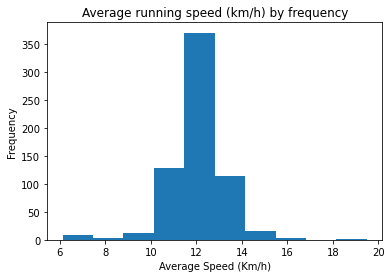

In [6]:
#Distribution of m running smeeds
plt.hist(run_df['Avg_speed_kmh'])
plt.xlabel("Average Speed (Km/h)")
plt.ylabel("Frequency")
plt.title("Average running speed (km/h) by frequency")

In [7]:
# Filter out runs with no heart rate data
hr_run_df = run_df[run_df['Average Heart Rate'].notna()]

## Disecting Strava's Relative Effort metric

Text(0.5, 1.0, "Understanding what factors into Strava's relative effort metric and what it mostly correlates to")

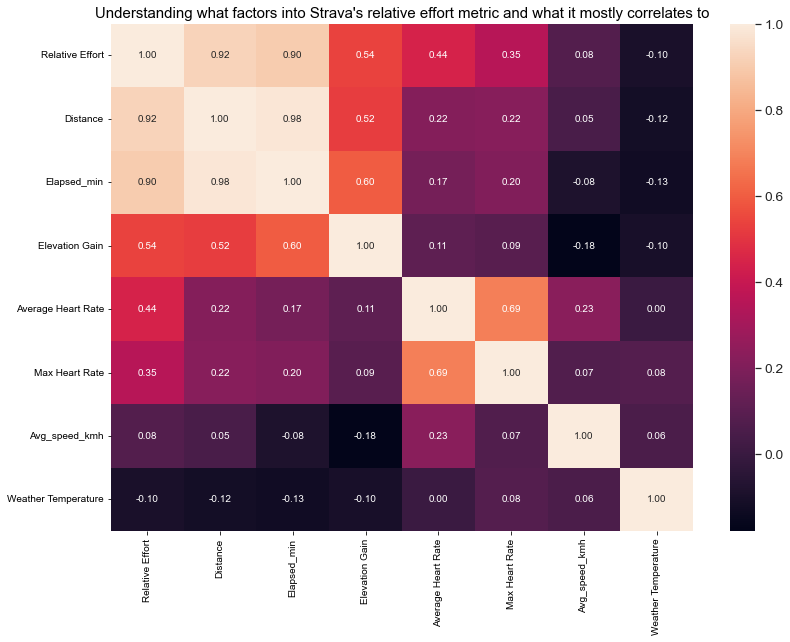

In [9]:
# focused heatmap - Relative Effort
tmp = hr_run_df[hr_run_df['Run_type'] == "Outdoor"]
rel_eff_corr_df = tmp[['Activity Date','Average Heart Rate','Weather Temperature','Relative Effort', 'Elapsed_min','Avg_speed_kmh','Elevation Gain','Max Heart Rate','Distance']]

corr = rel_eff_corr_df.corr()
# number of variables to be selected
k = len(corr.columns)

# finding the most correlated variables
cols = corr.nlargest(k, 'Relative Effort')['Relative Effort'].index
cm = np.corrcoef(rel_eff_corr_df[cols].values.T)

#plotting the heatmap
f, ax = plt.subplots(figsize=(12,9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.tight_layout()
plt.title("Understanding what factors into Strava's relative effort metric and what it mostly correlates to")

Text(0.5, 1.0, 'Relationship between Relative effort and elapsed time')

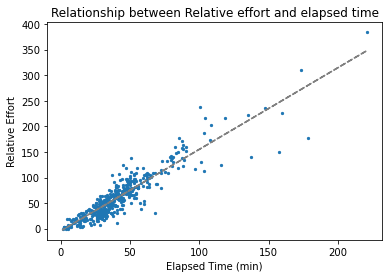

In [8]:
# Plotting relative effort versus elapsed time (min)

z = np.polyfit(hr_run_df['Elapsed_min'], hr_run_df['Relative Effort'], 1)
lin_reg = np.poly1d(z)

plt.scatter(hr_run_df['Elapsed_min'], hr_run_df['Relative Effort'], s=5)
plt.plot(hr_run_df['Elapsed_min'], lin_reg(hr_run_df['Elapsed_min']), color='grey', linestyle='dashed')
plt.xlabel("Elapsed Time (min)")
plt.ylabel("Relative Effort")
plt.title("Relationship between Relative effort and elapsed time")


## Over Time Running Trends

Text(0.5, 1.0, 'Weather temperature over time')

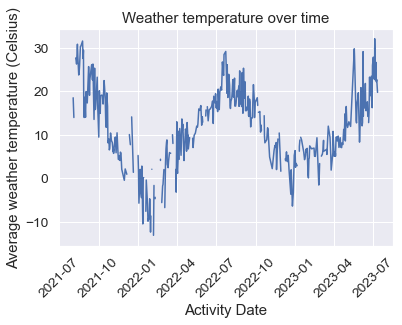

In [49]:
# Weather trend of my running life
plt.plot(hr_run_df['Activity Date'], hr_run_df['Weather Temperature'])
plt.xticks(rotation=45)
plt.ylabel("Average weather temperature (Celsius)")
plt.xlabel("Activity Date")
plt.title("Weather temperature over time")


In [30]:
weeks = [g for n, g in hr_run_df.groupby(pd.Grouper(key='Activity Date',freq='W'))]

week_index = []
for x in weeks:
    week_index.append(x['Activity Date'][-1 if len(x) > 0 else 0])

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,Elapsed_min,Avg_speed_kmh,Run_type
223,5883760956,2021-08-31 17:38:06,Easy on the legs,Run,Easy day but tough breathing,2174,6.03,165.0,30.0,False,...,8367046.0,0.0,NaN,0.64,16093.0,2.0,338.399994,36.233333,9.985281,Outdoor
938,5890647785,2021-09-01 22:50:06,Stanley tempo,Run,Had some buddy to chase down for the last 2kms...,2953,11.27,179.0,91.0,False,...,8158714.0,0.0,NaN,0.12,16093.0,4.0,333.799988,49.216667,13.739248,Outdoor
175,5905565695,2021-09-04 17:13:41,Running on empty stomach <<,Run,Killer kramp,1844,5.80,179.0,51.0,False,...,8367046.0,0.0,NaN,0.94,16093.0,2.0,293.200012,30.733333,11.323210,Outdoor


In [36]:
week_index = []
weekDist = []
for x in weeks:
    week_index.append(x['Activity Date'].iloc[-1])
    weekDist.append(x['Distance'].sum())



KeyError: -1

In [46]:
weeks[4]['Distance']

466     8.19
405     8.33
404     4.41
365     3.21
335     5.25
305    11.13
Name: Distance, dtype: float64